In [1]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset_name = "path-vqa"

In [3]:

if dataset_name == 'path-vqa':
    dataset = load_dataset("flaviagiammarino/path-vqa")
else:
    dataset = {
        'train': load_dataset("flaviagiammarino/vqa-rad", split="train"),
        'validation':load_dataset("flaviagiammarino/vqa-rad", split="test")
    }


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Question: is alpha smooth muscle actin immunohistochemical present?
Answer: no


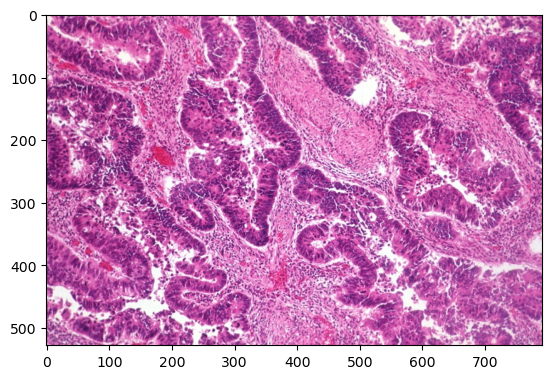

In [5]:
sample = dataset['train'][42]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [6]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [7]:
train_data = dataset['train'].select(range(5000))
val_data = dataset['validation'].select(range(500))

In [8]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding


text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                    )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                    )

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=True)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


In [10]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

num_epochs = 30
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
# scaler = torch.cuda.amp.GradScaler()


Question:  [CLS] what is present? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] liver [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


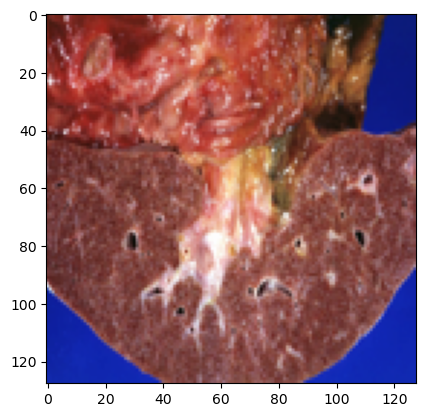

In [12]:
batch_idx = 0

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))


In [13]:


for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}")
    model.train()
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        
    print("Loss:", sum(total_loss))
    
    model.eval()
    eval_loss = 0
    total_accuracy = 0
    # for idx, batch in zip(tqdm(range(len(val_dataloader)), desc='Validating batch: ...'), val_dataloader):
    for batch in tqdm(val_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()

    tracking_information.append((sum(total_loss)/len(train_dataloader), eval_loss/len(val_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, sum(total_loss)/len(train_dataloader), eval_loss/len(val_dataloader), optimizer.param_groups[0]["lr"]))
    # scheduler.step()
    
    # if eval_loss < min_eval_loss:
    model.save_pretrained(f"Model/blip-{dataset_name}-model", from_pt=True)
    pickle.dump(tracking_information, open(f"Model/blip-{dataset_name}-model/tracking_information.pkl", "wb"))
    print(f"Saved model to Model/blip-{dataset_name}-model")
    #     min_eval_loss = eval_loss
    #     early_stopping_hook = 0
    # else:
    #     early_stopping_hook += 1
    #     if early_stopping_hook > patience:
    #         break


print("The finetuning process is complete!")


Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 381.04910510778427


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 - Training loss: 4.823406393769421 - Eval Loss: 1.1046379581093788 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 36.142903707921505


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 - Training loss: 0.4575051102268545 - Eval Loss: 0.5771498382091522 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 22.870955482125282


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 - Training loss: 0.2895057655965226 - Eval Loss: 0.5454453229904175 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 17.897392123937607


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 - Training loss: 0.22654926739161527 - Eval Loss: 0.544311847537756 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 5


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 14.162196964025497


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 - Training loss: 0.17926831600032275 - Eval Loss: 0.5524398945271969 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 6


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 11.223740696907043


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 - Training loss: 0.14207266704945626 - Eval Loss: 0.5784373208880424 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 7


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 9.07286450266838


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 - Training loss: 0.11484638610972633 - Eval Loss: 0.577198438346386 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 8


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 7.505697768181562


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 - Training loss: 0.09500883250862738 - Eval Loss: 0.5825523361563683 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 9


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 6.318980202078819


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 - Training loss: 0.07998709116555468 - Eval Loss: 0.5772997550666332 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 10


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 5.418536603450775


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 - Training loss: 0.06858907092975665 - Eval Loss: 0.6208704523742199 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 11


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 4.758381217718124


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 - Training loss: 0.06023267364200158 - Eval Loss: 0.6093065030872822 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 12


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 4.177244432270527


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 - Training loss: 0.05287651180089274 - Eval Loss: 0.6071481630206108 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 13


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 3.757616138085723


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 - Training loss: 0.04756476124159143 - Eval Loss: 0.6159138157963753 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 14


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 3.321886319667101


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 - Training loss: 0.04204919391983672 - Eval Loss: 0.6291164495050907 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 15


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.9356547128409147


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 - Training loss: 0.03716018623849259 - Eval Loss: 0.6225763782858849 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 16


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.5334774386137724


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 - Training loss: 0.032069334665997117 - Eval Loss: 0.6159477308392525 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 17


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.3702250816859305


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 - Training loss: 0.030002849135264943 - Eval Loss: 0.6311836279928684 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 18


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.110492876265198


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 - Training loss: 0.02671509969955947 - Eval Loss: 0.65625986084342 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 19


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.0847433283925056


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 - Training loss: 0.026389156055601336 - Eval Loss: 0.6256302297115326 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 20


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 2.164899437688291


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 - Training loss: 0.027403790350484698 - Eval Loss: 0.6377948969602585 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 21


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.7366883484646678


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 - Training loss: 0.021983396816008454 - Eval Loss: 0.6473204307258129 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 22


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.4830772634595633


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 - Training loss: 0.018773129917209662 - Eval Loss: 0.6525887213647366 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 23


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.3798263669013977


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 - Training loss: 0.017466156543055666 - Eval Loss: 0.6449987925589085 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 24


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.313821136020124


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 - Training loss: 0.016630647291393973 - Eval Loss: 0.6601823270320892 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 25


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.327506607864052


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 - Training loss: 0.01680388111220319 - Eval Loss: 0.6470456942915916 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 26


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.2842066129669547


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 - Training loss: 0.01625577991097411 - Eval Loss: 0.6571453623473644 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 27


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.3482068656012416


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 - Training loss: 0.017065909691154957 - Eval Loss: 0.6654538512229919 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 28


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.2376672476530075


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 - Training loss: 0.015666674020924146 - Eval Loss: 0.6583846621215343 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 29


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.2369911037385464


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 - Training loss: 0.01565811523719679 - Eval Loss: 0.6607712581753731 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
Epoch: 30


  0%|          | 0/79 [00:00<?, ?it/s]

Loss: 1.2244423762895167


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 - Training loss: 0.01549927058594325 - Eval Loss: 0.6806103885173798 - LR: 5e-05
Saved model to Model/blip-path-vqa-model
The finetuning process is complete!


Question:  what have lost their nuclei?
Predicted Answer:  the bisected kidneys
Actual Answer:  neutrophils


/data/vep52/miniforge3/envs/med_vqa/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


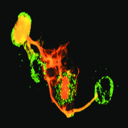

###################################################################
Question:  whose nuclei have been lost?
Predicted Answer:  this
Actual Answer:  neutrophils


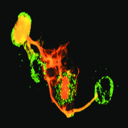

###################################################################
Question:  are two small pulmonary arterioles packed with laminated swirls of fetal squamous cells?
Predicted Answer:  yes
Actual Answer:  yes


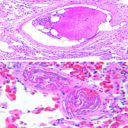

###################################################################
Question:  what is acute viral hepatitis characterized by?
Predicted Answer:  no
Actual Answer:  predominantly lymphocytic infiltrate


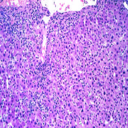

###################################################################
Question:  what do the cells have?
Predicted Answer:  the natural history of this form of diabetes
Actual Answer:  wavy nuclei


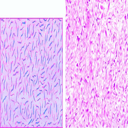

###################################################################
Question:  do the cells have wavy nuclei?
Predicted Answer:  no
Actual Answer:  yes


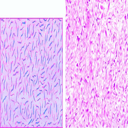

###################################################################
Question:  do individual myocardial fibres have wavy nuclei?
Predicted Answer:  no
Actual Answer:  no


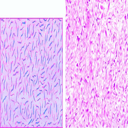

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


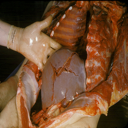

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  peritoneal carcinomatosis


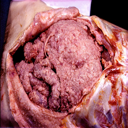

###################################################################
Question:  does this image show peritoneal carcinomatosis, metastatic tumor covering all of the abdominal viscera?
Predicted Answer:  yes
Actual Answer:  yes


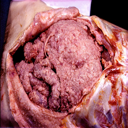

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


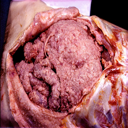

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  hemorrhage secondary to ruptured aneurysm


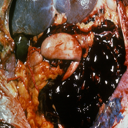

###################################################################
Question:  does this image show hemorrhage secondary to ruptured aneurysm?
Predicted Answer:  yes
Actual Answer:  yes


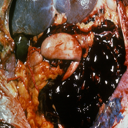

###################################################################
Question:  does abdomen show hemorrhage secondary to ruptured aneurysm?
Predicted Answer:  no
Actual Answer:  no


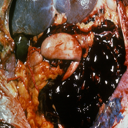

###################################################################
Question:  how is acute viral hepatitis characterized?
Predicted Answer:  by palisaded histiocytes
Actual Answer:  by predominantly lymphocytic infiltrate


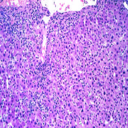

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


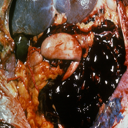

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


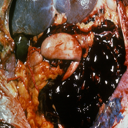

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


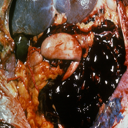

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


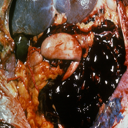

###################################################################
Question:  why does this image show bowel in situ with diffuse thickening of peritoneal surfaces?
Predicted Answer:  due to radiation for lung carcinoma and meningeal carcinomatosis
Actual Answer:  due to metastatic carcinoma breast primary i think


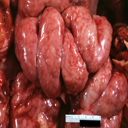

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  bowel in situ with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think


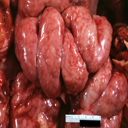

###################################################################
Question:  how does this image show bowel in situ?
Predicted Answer:  no
Actual Answer:  with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think


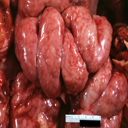

###################################################################
Question:  does this image show bowel in situ with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think?
Predicted Answer:  yes
Actual Answer:  yes


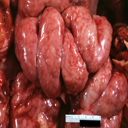

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


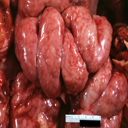

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


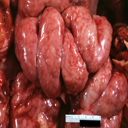

###################################################################
Question:  is acute viral hepatitis characterize by a predominantly lymphocytic infiltrate?
Predicted Answer:  no
Actual Answer:  yes


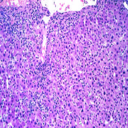

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


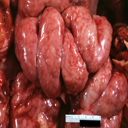

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


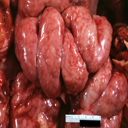

###################################################################
Question:  when does this image show a photo taken?
Predicted Answer:  no
Actual Answer:  during life large lesion


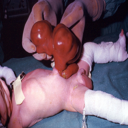

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  a photo taken during life large lesion


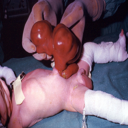

###################################################################
Question:  does this image show a photo taken during life large lesion?
Predicted Answer:  yes
Actual Answer:  yes


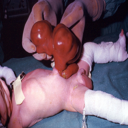

###################################################################
Question:  does omphalocele show a photo taken during life large lesion?
Predicted Answer:  yes
Actual Answer:  no


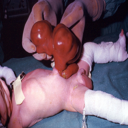

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern
Actual Answer:  abdomen


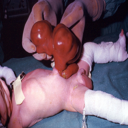

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


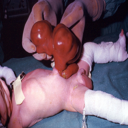

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern
Actual Answer:  omphalocele


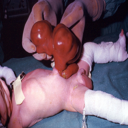

###################################################################
Question:  is omphalocele present?
Predicted Answer:  no
Actual Answer:  yes


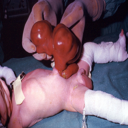

###################################################################
Question:  is the entire thickness of the epithelium characterize by a predominantly lymphocytic infiltrate?
Predicted Answer:  yes
Actual Answer:  no


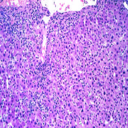

###################################################################
Question:  is omentum present?
Predicted Answer:  no
Actual Answer:  no


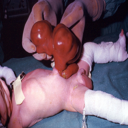

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


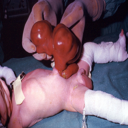

###################################################################
Question:  what taken during life large lesion?
Predicted Answer:  no
Actual Answer:  a photo


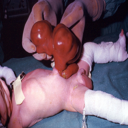

###################################################################
Question:  what is a photo taken?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  during life large lesion


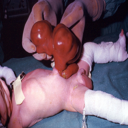

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern
Actual Answer:  abdomen


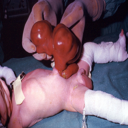

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern
Actual Answer:  omphalocele


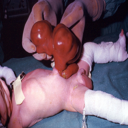

###################################################################
Question:  how is a photo taken during life lesion?
Predicted Answer:  no
Actual Answer:  large


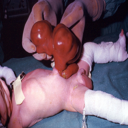

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit


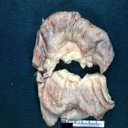

###################################################################
Question:  does this image show fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit?
Predicted Answer:  yes
Actual Answer:  yes


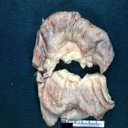

###################################################################
Question:  does acute peritonitis show fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit?
Predicted Answer:  no
Actual Answer:  no


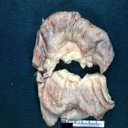

###################################################################
Question:  is schematic diagram of intimal thickening emphasize intimal smooth muscle cell migration and proliferation associated with extracellular matrix synthesis?
Predicted Answer:  yes
Actual Answer:  yes


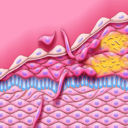

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


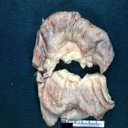

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


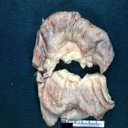

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


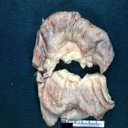

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


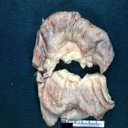

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  close - up view of metastatic lesions color not the best papillary serous adenocarcinoma of ovary


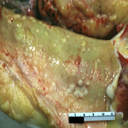

###################################################################
Question:  does this image show close - up view of metastatic lesions color not the best papillary serous adenocarcinoma of ovary?
Predicted Answer:  yes
Actual Answer:  yes


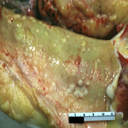

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


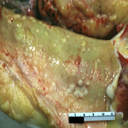

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


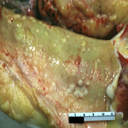

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


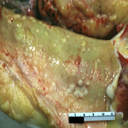

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


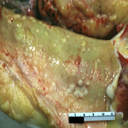

###################################################################
Question:  did nuclear pleomorphism emphasize intimal smooth muscle cell migration and proliferation associated with extracellular matrix synthesis?
Predicted Answer:  yes
Actual Answer:  no


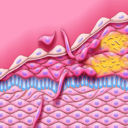

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


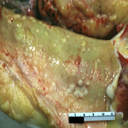

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


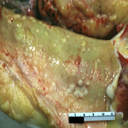

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


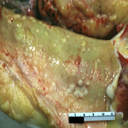

###################################################################
Question:  does this image show opened abdomen with ischemic appearing intestines bound by neoplastic adhesions good but not the best ovarian
Predicted Answer:  yes
Actual Answer:  yes


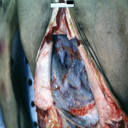

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


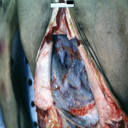

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


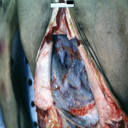

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  no


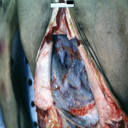

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


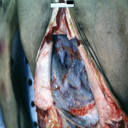

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


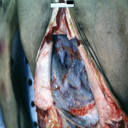

###################################################################
Question:  is an opened peritoneal cavity cause by fibrous band strangulation present?
Predicted Answer:  yes
Actual Answer:  no


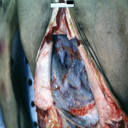

###################################################################
Question:  what is moderately narrowed by this eccentric lesion?
Predicted Answer:  the natural history of this form of diabetes
Actual Answer:  the lumen


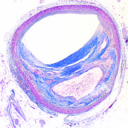

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


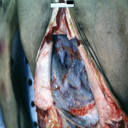

###################################################################
Question:  what bound by neoplastic adhesions good but not the best ovarian papillary adenocarcinoma?
Predicted Answer:  the tan - white tumor
Actual Answer:  opened abdomen with ischemic appearing intestines


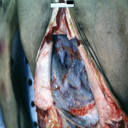

###################################################################
Question:  what is opened abdomen with ischemic appearing intestines bound?
Predicted Answer:  the natural history of this form of diabetes
Actual Answer:  by neoplastic adhesions good but not the best ovarian papillary adenocarcinoma


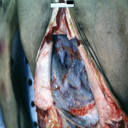

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


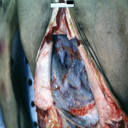

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


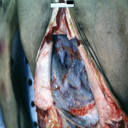

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  a very close - up view of typical gross lesions


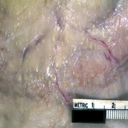

###################################################################
Question:  does this image show a very close - up view of typical gross lesions?
Predicted Answer:  yes
Actual Answer:  yes


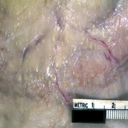

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


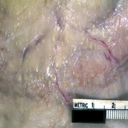

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


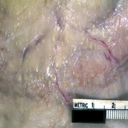

###################################################################
Question:  is opened abdominal cavity with massive tumor in omentum none apparent in liver nor over peritoneal surfaces gut present?
Predicted Answer:  yes
Actual Answer:  no


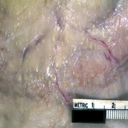

###################################################################
Question:  what is the lumen narrowed by?
Predicted Answer:  the natural history of this form of diabetes
Actual Answer:  eccentric lesion


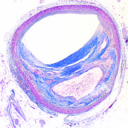

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


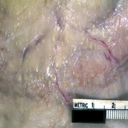

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


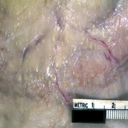

###################################################################
Question:  is tuberculosis present?
Predicted Answer:  no
Actual Answer:  no


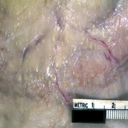

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  tuberculous peritonitis


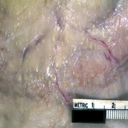

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  yes


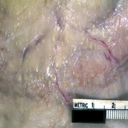

###################################################################
Question:  where is this area in the body?
Predicted Answer:  yes
Actual Answer:  abdomen


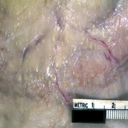

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


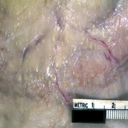

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  peritoneum


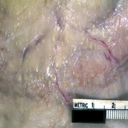

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  tuberculous peritonitis


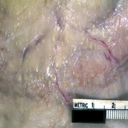

###################################################################
Question:  what does this image show?
Predicted Answer:  no
Actual Answer:  massive node enlargement like a lymphoma


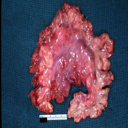

###################################################################
Question:  is the lumen moderately narrowed by this eccentric lesion, which leaves part of the vessel wall unaffected?
Predicted Answer:  yes
Actual Answer:  yes


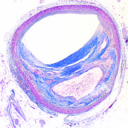

###################################################################
Question:  does this image show massive node enlargement like a lymphoma?
Predicted Answer:  yes
Actual Answer:  yes


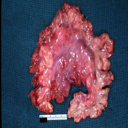

###################################################################
Question:  does abdomen show massive node enlargement like a lymphoma?
Predicted Answer:  no
Actual Answer:  no


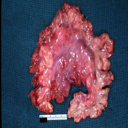

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  abdomen


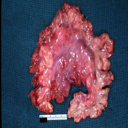

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


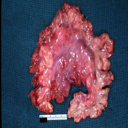

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  no


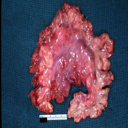

###################################################################
Question:  what is present?
Predicted Answer:  an expansile growth pattern with pushing circumscribed borders
Actual Answer:  mesentery


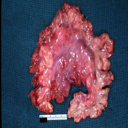

###################################################################
Question:  is mesentery present?
Predicted Answer:  no
Actual Answer:  yes


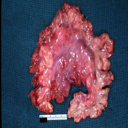

###################################################################
Question:  is carcinomatosis present?
Predicted Answer:  no
Actual Answer:  no


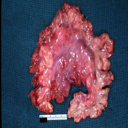

###################################################################


In [14]:
# add batch dimension + move to GPU|
model.eval()
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

In [15]:
torch.cuda.empty_cache()

In [16]:
# add batch dimension + move to GPU|
model.eval()

answers = []
predicted_answers = []

for x in tqdm(range(len(val_vqa_dataset))):
    sample = val_vqa_dataset[x]
    # print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    predicted_answers.append(text_processor.decode(outputs[0],skip_special_tokens=True))
    answers.append(text_processor.decode(sample['labels'][0], skip_special_tokens=True))


  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
len(answers), len(predicted_answers)

(500, 500)

In [25]:
from difflib import SequenceMatcher

hypotheses = []
references = []

ratios = []

# correct 
tp = 0
tn = 0
fp = 0
fn = 0

for a, pa in zip(answers, predicted_answers):
    if a in ['yes','no']:
        if pa.startswith(a):
            if a == 'yes' and pa == 'yes':
                tp += 1
            elif pa == 'no' or pa.startswith('no ') or pa.startswith('non'):
                tn += 1
        else:
            if a == 'yes':
                fn += 1
            else:
                fp += 1
    else:
        # hypotheses.append(pa)
        # references.append(a)
        ratios.append(SequenceMatcher(a=a, b=pa).ratio())

accuracy = (tp+tn)/(len(answers)-len(ratios))
ratio = sum(ratios)/len(ratios)
f"exact_match: {accuracy}", f"similarity: {ratio}", tp, tn, fp, fn

('exact_match: 0.6260869565217392',
 'similarity: 0.1748577548793857',
 59,
 85,
 12,
 74)

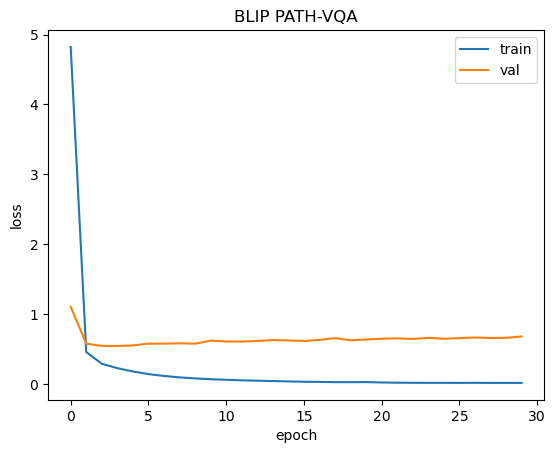

In [21]:
import numpy as np

arr = np.array(tracking_information)

plt.figure(1)
plt.clf()
plt.plot(arr[:,0], label='train')
plt.plot(arr[:,1], label='val')
plt.title('BLIP PATH-VQA')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
_=plt.show()

In [22]:
import json
with open(f"Model/blip-{dataset_name}-model/answers.json", "w") as wf:
    json.dump(answers, wf)
with open(f"Model/blip-{dataset_name}-model/predicted_answers.json", "w") as wf:
    json.dump(predicted_answers, wf)   